In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import sys
sys.path.append('..')

In [2]:

import numpy as np
import networkx as nx


class Community(nx.Graph):
    """
    This class inherits the nx.Graph class to define the community object. 
    The community is a undirected graph, where each node is a household.
    The edges are the social ties between households.

    To create a community object, we can use the following code:
    community = Community()

    To add nodes and edges to the community, we can use the following code:
    community.add_nodes_from([0,1,2,3,4])
    community.add_edges_from([(0,1), (0,2), (0,3), (0,4), (1,2), (1,3), (2,3), (3,4)])

    To add attributes to the nodes, we can use the following code:
    community.nodes[1]['name'] = 'household1'
    community.nodes[2]['name'] = 'household2'
    community.nodes[1]['transp'] = 7
    community.nodes[2]['transp'] = 5

    To add attributes to the edges, we can use the following code:
    community.edges[1,2]['weight'] = 3
    community.edges[1,2]['type'] = "strong_tie"
    
    After creating the nodes, to generate the resource inventory of each household, we can use the following code:
    community.generate_resource_inventory(amount=[0,1,2,3,4], pmf=[0.1, 0.2, 0.3, 0.2, 0.2])

    To generate the sharing preference of each household, we can use the following code:
    community.generate_sharing_preference(recipient=[0,1,2,3], pmf=[0.1, 0.2, 0.3, 0.4])
    """
    def __init__(self) -> None:
        super().__init__()

    def set_resource_inventory(self, resource_inventory:list, name='transp'):
        """
        This function sets the resource inventory of each household.
        Parameters:
            resource_inventory: a list of resource inventory.
            name: the name of the resource.
        """
        assert len(resource_inventory) == len(self.nodes()) # The length of amount_list should be equal to the number of households.
        for ind, household in enumerate(self.nodes()):
            self.nodes[household][name] = resource_inventory[ind]
    
    def generate_resource_inventory(self, support:list, pmf:list, name='transp', seed=0):
        """
        This function generates the resource inventory of each household.
        Parameters:
            support: possible values for resource inventory.
            pmf: probability mass w.r.t. values in the value_set.
            name: the name of the resource.
            seed: the seed of the random generator.
        """
        assert abs(1 - sum(pmf)) <= 1e-12 # The sum of the probability list should be 1.
        assert len(support) == len(pmf) # The length of amount_list should be equal to the length of p_list.
        np.random.seed(seed)
        for household in self.nodes():
            self.nodes[household][name] = np.random.choice(support, p=pmf)

    def get_resource_inventory(self, name='transp') -> list:
        """
        This function returns the resource inventory of each household.
        """
        resource_inventory = []
        for household in self.nodes():
            resource_inventory.append(self.nodes[household][name])
        return resource_inventory

    def set_sharing_preference(self, recipient:list, name="transp_share_preference"):
        """
        This function sets the sharing preference of each household.
        Parameters:
            recipient: list, the list of the recipient of sharing.
        """
        for ind, household in enumerate(self.nodes()):
            self.nodes[household][name] = recipient[ind]

    def generate_sharing_preference(self, recipient:list, pmf:list, name="transp_share_preference", seed=0):
        """
        Method:
            This function generates the sharing preference of each household.
        Parameters:
            recipient: list, the list of the recipient of sharing.
        """
        assert abs(sum(pmf) - 1) <= 1e-12  # The sum of the probability list should be 1.
        assert len(recipient) == len(pmf) # The length of amount_list should be equal to the length of p_list.
        np.random.seed(seed)
        for household in self.nodes():
            self.nodes[household][name] = np.random.choice(recipient, p=pmf)

    def get_sharing_preference(self, name="transp_share_preference") -> list:
        """
        This function returns the sharing preference of each household.
        """
        sharing_preference = []
        for household in self.nodes():
            sharing_preference.append(self.nodes[household][name])
        return sharing_preference

    def generate_corrlated_sharing_preference(self, recipient:list, pmf_mat:np.matrix, cov_mat:np.matrix, 
                                              name:list=["water_share_preference",
                                                         "food_share_preference",
                                                         "meds_share_preference",
                                                         "transp_share_preference",
                                                         "comm_share_preference",
                                                         "faid_share_preference",
                                                         "warm_share_preference",
                                                         "sani_share_preference",
                                                         "power_share_preference",
                                                         "shelter_share_preference"], 
                                                         seed=0):
        """
        Method:
            This function generates the sharing preference of each household.
        Parameters:
            recipient: list, the list of the recipient of sharing.
            pmf_mat: the probability mass function matrix. Each row is the pmf of a resource.
            cov_mat: the covariance matrix of the resources.
            name: the name of the sharing preference.
            seed: the seed of the random generator.     
        """
        
        sum_pmf = pmf_mat.sum(axis=1)
        assert np.abs(sum_pmf - np.ones_like(sum_pmf)) <= 1e-12  # The sum of the probability list should be 1.
        assert len(recipient) == len(pmf_mat.shape[1]) # The length of amount_list should be equal to the number of columns in pmf_mat.
        assert cov_mat.shape[0] == cov_mat.shape[1] # asset cov_mat is a square matrix
        assert np.all(np.linalg.eigvals(cov_mat) >= 0) # asset cov_mat is a positive semi-definite matrix
        assert len(name) == cov_mat.shape[0] # the length of name should be equal to the number of resources

        uncorr_sharing_preferences = np.zeros((pmf_mat.shape[0], len(self.nodes())))

        np.random.seed(0)
        for i in range(uncorr_sharing_preferences.shape[0]):
            for j in range(uncorr_sharing_preferences.shape[1]):
                uncorr_sharing_preferences[i, j] = np.random.choice(recipient, p=pmf_mat[i, :])
        
        corr_sharing_preferences = np.linalg.cholesky(cov_mat) @ uncorr_sharing_preferences
        # To be updated. The outcome is not integer.
        return 0

    def generate_social_ties(self, degrees:list, distance_matrix:np.matrix, distance_decay_alpha:float=-1.35, seed:int=0):
        """
        This function generates the social ties of the community.
        """
        assert len(degrees) == len(self.nodes())
        assert distance_matrix.shape[0] == len(self.nodes())
        assert distance_matrix.shape[1] == len(self.nodes())
        np.random.seed(seed)

        # make sure the sum of the degrees is even
        degrees = np.array(degrees)
        if degrees.sum() % 2 != 0:
            degrees[0] += 1

        # set the diagonal of the distance matrix to be infinity
        # so that the distance between a household and itself is infinity
        np.fill_diagonal(distance_matrix, np.inf)

        # calculate the probability of having a tie
        prob_matrix = self._distance_decay_function(distance_matrix, alpha=distance_decay_alpha)

        # generate the social network
        social_tie_matrix = np.zeros(prob_matrix.shape, dtype=int)
        accumulated_degree_list = np.zeros(len(degrees), dtype=int)

        for i in range(np.shape(prob_matrix)[0]):
            remain_degree = degrees - accumulated_degree_list # the number of remaining degree for each household
            if remain_degree[i] <= 0:
                continue
            reachable_households = np.where(remain_degree > 0)[0] # the households that are reachable from household i
            select_probability = prob_matrix[i, reachable_households]/np.sum(prob_matrix[i, reachable_households])
            selected_households = np.random.choice(reachable_households, 
                                            size=remain_degree[i], 
                                            p=select_probability,
                                            replace=True)
            # To be strict, replace should be False. However, in that case, the degree 
            # requirement is very likely not satisfied. This problem is a standalone 
            # network configuration problem, which is not the focus of this paper.
            social_tie_matrix[i, selected_households] = 1
            social_tie_matrix[selected_households, i] = 1
            accumulated_degree_list = np.sum(social_tie_matrix, axis=1)

        self.add_edges_from(np.argwhere(social_tie_matrix==1))
        
    def _distance_decay_function(self, distance, alpha=-1.35):
        """
        Method:
            The distance decay function is used to calculate the probability of two households having a tie.
        Parameters:
            distance: the distance between two households
            alpha: the decay rate
        return:
            the probability of two households having a tie
        Reference:
            alpha values:
            (alpha = -1.2) Liben-Nowell, D., Novak, J., Kumar, R., Raghavan, P., Tomkins, A., 2005. Geographic routing in social networks. 
                Proceedings of the National Academy of Sciences 102, 11623–11628.
            (alpha = -0.74) Xu, Y., Santi, P., & Ratti, C. (2022). Beyond distance decay: Discover homophily in spatially embedded social networks. 
                Annals of the American Association of Geographers, 112(2), 505-521.
        """
        eps = 1e-12 # to avoid division by zero
        return (distance + eps) ** alpha
    
    def split_social_ties(self, types:list, pmf:list, seed=0):
        """
        This function splits the social ties into different types.
        """
        assert sum(pmf) == 1
        assert len(pmf) == len(types)
        np.random.seed(seed)

        for tie in self.edges():
            self.edges[tie]['type'] = np.random.choice(types, p=pmf)

    def get_social_tie_matrix(self, type:str=None) -> np.array: 
        """
        This function returns the social tie matrix.
        """
        if type is None:
            return nx.adjacency_matrix(self).todense()
        else:
            # return the adjacency matrix of edges with the given type
            matrix = np.zeros((len(self.nodes()), len(self.nodes())), dtype=int)
            for tie in self.edges():
                if self.edges[tie]['type'] == type:
                    matrix[tie[0], tie[1]] = 1
                    matrix[tie[1], tie[0]] = 1
            return matrix

    def get_share_priority_matrix(self, sharing_preference:str, priority=[3, 2, 1]):
        """
        Method:
            Generate the willingness to share matrix.
        Parameters:
            sharing_preference: the name of sharing preference
            priority: the priority of sharing (for link weight)
        Return:
            priority_matrix: the sharing priority matrix
        """
        strong_tie_matrix = self.get_social_tie_matrix(type='strong')
        weak_tie_matrix = self.get_social_tie_matrix(type='weak')
        
        n = strong_tie_matrix.shape[0]
        stranger_matrix = np.ones(shape=(n, n)) - self.get_social_tie_matrix()

        # create willingness to share matrix
        priority_matrix = np.zeros((n, n))

        for n in self.nodes():
            share_preferece_val = self.nodes[n][sharing_preference]
            if share_preferece_val == 0: # no sharing
                priority_matrix[n, :] = (0 * strong_tie_matrix[n, :])
            if share_preferece_val == 1: # share with strong ties
                priority_matrix[n, :] = (priority[0] * strong_tie_matrix[n, :])
            if share_preferece_val == 2: # share with strong ties and weak ties
                priority_matrix[n, :] = (priority[0] * strong_tie_matrix[n, :]
                                        + priority[1] * weak_tie_matrix[n, :])
            if share_preferece_val == 3: # share with strong ties, weak ties and strangers
                priority_matrix[n, :] = (priority[0] * strong_tie_matrix[n, :]
                                        + priority[1] * weak_tie_matrix[n, :]
                                        + priority[2] * stranger_matrix[n, :])
        return priority_matrix
    
    def get_share_network(self, sharing_preference, priority=[3, 2, 1]):
        """
        Method:
            Construct the share network based on the sharing preference and social ties.
        Parameters:
            sharing_preference: the name of sharing preference
            priority: the priority of sharing (for link weight)
        Return:
            G: the share network
        """
        priority_matrix = self.get_share_priority_matrix(sharing_preference, priority)
        G = nx.from_numpy_array(priority_matrix, create_using=nx.DiGraph)
        # set the node attributes
        for n in G.nodes():
            G.nodes[n].update(self.nodes[n])
        return G
    

In [3]:
PARAMS = {
    'community': 'southpark',
    'experiment_name': 'node_degree',
    # resource types should be the same as the column names in the resource_preference_pmf and resource_inventory_pmf
    'resource_types': ['water', 'food', 'meds', 'transp', 'comm',
                       'faid', 'warm', 'sani', 'power', 'shelter'], 
    'tau': 5, # isolation days
    'num_scenarios': 100,
    'n': 0.82661451, # degree distribution parameter
    'p': 0.06686762, # degree distribution parameter
    'social_tie': {
        'types': ['strong', 'weak'],
        'pmf':  [0.298, 0.702]
    },
    'distance_decay_alpha': -1.43, # distance decay parameter
    'distances_mat': np.load('data/southpark_distance_matrix.npy'), # distance matrix
    'sharing_preference_pmf': pd.read_csv('data/southpark_share_pref_PMF.csv'), # sharing preference matrix
    'sharing_priority': [3, 2, 1], # sharing priorities to [strong tie, weak tie, stranger]
    'resource_inventory_pmf': pd.read_csv('data/southpark_resource_distr_PMF.csv') # resource inventory distribution
}

In [4]:
def p2p_single_resource_sharing(n:float, # negative binomial distribution parameter
                                p:float, # negative binomial distribution parameter
                                degree_ratio:float, # degree ratio
                                distance_decay_alpha:float, # distance decay parameter
                                distance_mat:np.matrix, # distance matrix
                                social_tie_pmf:list,
                                social_tie_types:list = ['strong', 'weak'],
                                seed:int=0):
    """Step 1: Community-based social network construction"""
    # create a community
    community = Community()
    num_nodes = distance_mat.shape[0]
    community.add_nodes_from(range(num_nodes))

    # generate social ties
    np.random.seed(seed)
    degree_list = np.random.negative_binomial(n, p, size=num_nodes)
    degree_list = degree_list * degree_ratio
    degree_list = degree_list.astype(int)
    community.generate_social_ties(degrees=degree_list, 
                                   distance_matrix=distance_mat, 
                                   distance_decay_alpha=distance_decay_alpha, 
                                   seed=seed+1)
    community.split_social_ties(types=social_tie_types, 
                                pmf=social_tie_pmf, 
                                seed=seed+2)
    
    strong_tie_matrix = community.get_social_tie_matrix(type='strong')
    weak_tie_matrix = community.get_social_tie_matrix(type='weak')

    return strong_tie_matrix, weak_tie_matrix

In [5]:
# # main script for running the status quo model
# # for degree_ratio in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]:
# for degree_ratio in [1.0]:

#     for sce in range(PARAMS['num_scenarios']):
        
#         # directory name for saving the results
#         dir = PARAMS['community'] + '/' + PARAMS['experiment_name'] + '/tau_' + str(PARAMS['tau']) # directory name
#         # Create a dataframe to store the results
#         inventory_df = pd.DataFrame(columns=PARAMS['resource_types'])
#         resource_df = pd.DataFrame(columns=PARAMS['resource_types'])
        
#         # run the model for each resource type
#         strong_tie_matrix, weak_tie_matrix = p2p_single_resource_sharing(
#                                                                     n=PARAMS['n'],
#                                                                     p=PARAMS['p'],
#                                                                     degree_ratio=degree_ratio,
#                                                                     social_tie_types = PARAMS['social_tie']['types'],
#                                                                     social_tie_pmf = PARAMS['social_tie']['pmf'],
#                                                                     distance_decay_alpha = PARAMS['distance_decay_alpha'],
#                                                                     distance_mat = PARAMS['distances_mat'],
#                                                                     seed=sce)
#         # save sparse matrix
#         sp.save_npz('data/southpark_strong_tie_matrix_degree_{}_sce_{}.npz'.format(degree_ratio, sce), sp.csr_matrix(strong_tie_matrix))
#         sp.save_npz('data/southpark_weak_tie_matrix_degree_{}_sce_{}.npz'.format(degree_ratio, sce), sp.csr_matrix(weak_tie_matrix))

In [6]:
# read the address data
households_df = pd.read_csv('data/southpark_address.csv')
households_df


household_areas = households_df['area']
num_households = np.array([
    household_areas.value_counts()['A'],
    household_areas.value_counts()['B'],
    household_areas.value_counts()['C'],
    household_areas.value_counts()['D'],
    household_areas.value_counts()['E'],
    household_areas.value_counts()['F']
])

# Define a dictionary to map area letters to indices
area_indices = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

# Initialize a 7x7 matrix with zeros (area2area social tie matrix)
strong_tie_area_matrix = np.zeros((6, 6))
weak_tie_area_matrix = np.zeros((6, 6))

# parameters
scenarios = np.arange(0, 100)

# Loop through the scenarios
for i, s in enumerate(scenarios):
    tmp_strong = np.load(f'data/southpark_strong_tie_matrix_degree_{1.0}_sce_{s}.npz')
    tmp_weak = np.load(f'data/southpark_weak_tie_matrix_degree_{1.0}_sce_{s}.npz')
    # transfer to full matrix
    strong_tie_matrix = sp.csr_matrix((tmp_strong['data'], tmp_strong['indices'], tmp_strong['indptr']), shape=tmp_strong['shape']).toarray()
    weak_tie_matrix = sp.csr_matrix((tmp_weak['data'], tmp_weak['indices'], tmp_weak['indptr']), shape=tmp_weak['shape']).toarray()
    social_tie_matrix = strong_tie_matrix + weak_tie_matrix

    # Loop through the social tie matrix
    for i in range(np.shape(social_tie_matrix)[0]):
        for j in range(np.shape(social_tie_matrix)[1]):
            if social_tie_matrix[i, j] == 1:
                # Determine the area of the household
                area_i = household_areas[i]
                area_j = household_areas[j]

                # Determine the row index based on the area
                row = area_indices[area_i]
                col = area_indices[area_j]

                # Add 1 to the strong tie matrix if the strong tie matrix has 1
                if strong_tie_matrix[i, j] == 1:
                    strong_tie_area_matrix[row, col] += 1
                # Add 1 to the weak tie matrix if the weak tie matrix has 1
                elif weak_tie_matrix[i, j] == 1:
                    weak_tie_area_matrix[row, col] += 1

# count the number of household in each area
households_df['area'].value_counts()

print("Area average strong tie matrix:")
display(np.round(strong_tie_area_matrix/num_households/len(scenarios), decimals=2))
print("Area average weak tie matrix:")
display(np.round(weak_tie_area_matrix/num_households/len(scenarios), decimals=2))
print("Area average social tie matrix:")
display(np.round((strong_tie_area_matrix + weak_tie_area_matrix)/num_households/len(scenarios), decimals=2))
print("Total number of ties:")
print(np.sum(strong_tie_area_matrix + weak_tie_area_matrix)/len(scenarios))
print("Average number of ties per household:")
print(np.sum(strong_tie_area_matrix + weak_tie_area_matrix)/num_households/len(scenarios))

Area average strong tie matrix:


array([[1.73, 0.52, 0.31, 0.13, 0.25, 0.11],
       [0.43, 1.48, 0.36, 0.09, 0.14, 0.1 ],
       [0.68, 0.98, 2.04, 0.29, 0.49, 0.46],
       [0.08, 0.07, 0.08, 1.7 , 0.33, 0.31],
       [0.39, 0.26, 0.34, 0.81, 1.72, 0.79],
       [0.05, 0.05, 0.08, 0.19, 0.2 , 1.49]])

Area average weak tie matrix:


array([[3.99, 1.23, 0.72, 0.31, 0.6 , 0.27],
       [1.01, 3.48, 0.84, 0.2 , 0.33, 0.24],
       [1.62, 2.29, 4.82, 0.68, 1.14, 1.08],
       [0.2 , 0.16, 0.19, 4.02, 0.77, 0.75],
       [0.94, 0.62, 0.8 , 1.9 , 4.01, 1.85],
       [0.11, 0.11, 0.19, 0.47, 0.47, 3.48]])

Area average social tie matrix:


array([[5.72, 1.74, 1.03, 0.43, 0.86, 0.38],
       [1.44, 4.96, 1.21, 0.29, 0.47, 0.34],
       [2.3 , 3.27, 6.86, 0.97, 1.63, 1.54],
       [0.28, 0.22, 0.28, 5.72, 1.11, 1.06],
       [1.34, 0.89, 1.14, 2.71, 5.73, 2.64],
       [0.15, 0.16, 0.27, 0.66, 0.67, 4.97]])

Total number of ties:
14947.44
Average number of ties per household:
[ 72.20985507  87.41192982  32.21431034 113.23818182  46.27690402
 182.28585366]


In [7]:
from scipy.stats import nbinom
def neg_binom(x, p, n):
    return nbinom.pmf(x, n, p)

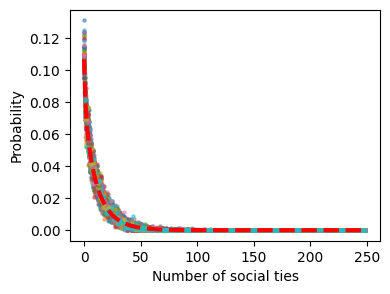

In [8]:
fig = plt.subplots(1, 1, figsize=(4, 3))
plt.xlabel(f'Number of social ties')
plt.ylabel(f'Probability')

x = np.arange(0, 250, 1)
plt.plot(x, neg_binom(x, 0.06686762, 0.82661451), color='r',
            linestyle='--', linewidth=3, label=r'Fitted NB distribution')

for i, s in enumerate(scenarios):
    tmp_strong = np.load(f'data/southpark_strong_tie_matrix_degree_{1.0}_sce_{s}.npz')
    tmp_weak = np.load(f'data/southpark_weak_tie_matrix_degree_{1.0}_sce_{s}.npz')
    # transfer to full matrix
    strong_tie_matrix = sp.csr_matrix((tmp_strong['data'], tmp_strong['indices'], tmp_strong['indptr']), shape=tmp_strong['shape']).toarray()
    weak_tie_matrix = sp.csr_matrix((tmp_weak['data'], tmp_weak['indices'], tmp_weak['indptr']), shape=tmp_weak['shape']).toarray()
    social_tie_matrix = strong_tie_matrix + weak_tie_matrix

    # sum by column
    sum_tie = np.sum(social_tie_matrix, axis=0)

    # print the tie distribution
    data = np.histogram(sum_tie, bins=range(250), density=True)
    plt.scatter(data[1][:-1], data[0], alpha=0.5, s=5)


Text(0.5, 1.0, 'Generated Social Ties')

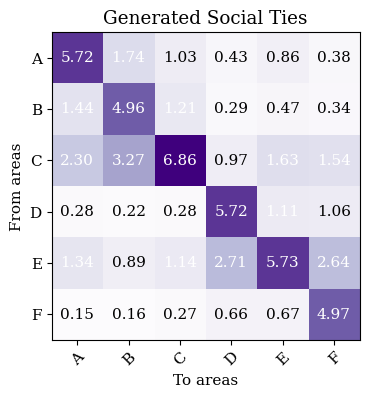

In [9]:
# create data
data = (strong_tie_area_matrix + weak_tie_area_matrix)/num_households/len(scenarios)
# Set font properties
font = {'family': 'serif', 'weight': 'normal', 'size': 11}
plt.rc('font', **font)

# create figure and axes
fig, ax = plt.subplots(figsize=(4, 4))

# plot data as grid
im = ax.imshow(data, cmap='Purples')

# add colorbar
# cbar = ax.figure.colorbar(im, ax=ax)

# set axis labels
ax.set_xticks(np.arange(data.shape[1]))
ax.set_yticks(np.arange(data.shape[0]))
ax.set_xticklabels(np.arange(data.shape[1])+1)
ax.set_yticklabels(np.arange(data.shape[0])+1)

# set axis tick labels to be readable
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# add title
# ax.set_title("2D Grid Plot")
ax.set_xlabel('To areas')
ax.set_ylabel('From areas')
# set x-ticklabels as A, B, C, D, E, F, G
ax.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F'])
# set y-ticklabels as A, B, C, D, E, F, G
ax.set_yticklabels(['A', 'B', 'C', 'D', 'E', 'F'])

# add text annotations for each cell
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        text_color = "white" if data[i, j] > np.median(data) else "black"
        ax.text(j, i, f'{data[i, j]:.2f}', ha="center", va="center", color=text_color)
ax.set_title('Generated Social Ties')
